### Importing libraries

In [1]:
import random
import imageio
import time
import numpy as np
from argparse import ArgumentParser
from itertools import chain

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Subset


from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

### Hyper parameters

In [2]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
fashion = False
batch_size = 128
n_epochs = 60
lr = 3e-4
num_samples_generate = 16

### Preprocessing data

In [4]:
transform = Compose([
    # ToTensor(),
    # Lambda(lambda x: (x - 0.5) * 2)],
    ToTensor(), # Scales data into [0,1]
    Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 239kB/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
great_min = 1
great_max = 0

for i in range(len(dataset)):
    temp_min = torch.min(dataset[i][0])
    temp_max = torch.max(dataset[i][0])
    if temp_min < great_min:
        great_min = temp_min
    if temp_max > great_max:
        great_max = temp_max

print(great_min)
print(great_max)

tensor(-1.)
tensor(1.)


In [ ]:
loader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DDPM architecture

In [ ]:
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=300, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta = None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]
        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)
        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

### The forward process (one-step):

$q(x_t | x_0) = N(x_t; \sqrt{\bar{\alpha_t}}x_0 , (1 - \bar{\alpha_t})I)$

In [ ]:
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0]

        show_images(imgs)

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))])
            )
        break

### Inference Step

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(x_t, t) ) + \sigma_t z \; \; \; (t\in \{ 1, ..., T \}) \; \; \; z \sim N(0, I)$

In [ ]:
def show_images(images, save = False, show = True, epoch = -1, batch_size = -1, index = -1, forward = False):

    # path_to_save = "/content/gdrive/MyDrive/Generative_Output"

    # Convert Tensor to numpy
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    if show:
      fig = plt.figure(figsize=(5, 5))
      idx = 0
      for r in range(rows):
          for c in range(cols):
              fig.add_subplot(rows, cols, idx + 1)
              if idx < len(images):
                  plt.imshow(images[idx][0], cmap="gray")
                  plt.axis('off')
                  # if save:
                  #   image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(idx)+"_"+ str(index) +".png"
                  #   plt.savefig(image_name)
                  idx += 1
      plt.show()
      plt.close(fig)

In [ ]:
def inference_step(index, show, save):
    start = time.time()
    generated = generate_new_images(
            ddpm,
            n_samples = num_samples_generate,
            device = device
          )
    end = time.time()
    # print("Output shape: ", np.asarray(generated).shape)

    exe_time = end - start
    inference_exe_time.append(exe_time)

    if show:
      print("Execution time for ", n_epochs, " epochs and ", batch_size, " batch sizes: ", exe_time)
      show_images(generated, save, show, n_epochs, batch_size, index, forward = True)

In [ ]:
def generate_new_images(ddpm, n_samples= num_samples_generate, device=None, c=1, h=28, w=28):

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                x = x + sigma_t * z
    # Convert Tensor to numpy
    if type(x) is torch.Tensor:
        x = x.detach().cpu().numpy()
        # print("Shape of generated images: ", x.shape)

    generated_images.append(x)

    return x

In [ ]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

### Embedding time in the network

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

### The basic U-Net
This network recieves $x_t$ and returns $x_{t-1}$

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
def plot_inference_exe_time(inference_exe_time):
    target = []
    for t in inference_exe_time:
        if t > 0.05:
          target.append(t)

    plt.title("Inference execution times")
    plt.scatter(np.arange(0,len(target)), target)

### Building the DDPM

In [ ]:
n_steps, min_beta, max_beta = 300, 10 ** -4, 0.02  # Originally used by the authors (n_steps is the T parameter for training)
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
def print_model_summary(model, indent=0):
    print(' ' * indent + model.__class__.__name__)
    for name, module in model.named_children():
      if name.startswith('b'):
          if name.startswith('b_out'):
              my_block = module[-1]
          else:
              my_block = module[0]
          for sub_name, sub_module in my_block.named_children():
            if sub_name == 'ln':
                print(' ' * (indent + 4) + f"U-Net Block:\t{sub_module}")
                print(' ' * (indent + 4) + '==================================\n')
                break
      if name.startswith('te'):
            last_linear = module[-1]
            print(' ' * (indent + 4) + f"Time Embedding:\t{last_linear}")

      if name.startswith('conv_out'):
          print(' ' * (indent + 4) + f"Output Conv:\t{module}")

    if isinstance(module, nn.Module) and list(module.children()):
        print_model_summary(module, indent + 4)

In [ ]:
# my_unet = MyUNet(n_steps)
print_model_summary(ddpm)

MyDDPM
    MyUNet
        Time Embedding:	Linear(in_features=1, out_features=1, bias=True)
        U-Net Block:	LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)

        Time Embedding:	Linear(in_features=10, out_features=10, bias=True)
        U-Net Block:	LayerNorm((10, 14, 14), eps=1e-05, elementwise_affine=True)

        Time Embedding:	Linear(in_features=20, out_features=20, bias=True)
        U-Net Block:	LayerNorm((20, 7, 7), eps=1e-05, elementwise_affine=True)

        Time Embedding:	Linear(in_features=40, out_features=40, bias=True)
        U-Net Block:	LayerNorm((40, 3, 3), eps=1e-05, elementwise_affine=True)

        Time Embedding:	Linear(in_features=80, out_features=80, bias=True)
        U-Net Block:	LayerNorm((80, 7, 7), eps=1e-05, elementwise_affine=True)

        Time Embedding:	Linear(in_features=40, out_features=40, bias=True)
        U-Net Block:	LayerNorm((40, 14, 14), eps=1e-05, elementwise_affine=True)

        Time Embedding:	Linear(in_features=20, ou

In [ ]:
show_forward(ddpm, loader, device)

### Training the network $ϵ_{\theta}(x_t, t)$

In [ ]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=True, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)
            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)
            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)
    return ddpm

In [ ]:
optim = Adam(ddpm.parameters(), lr)

In [ ]:
print(n_steps)
print(batch_size)
print(n_epochs)
print(lr)

300
128
60
0.0003


In [ ]:
import time
start = time.time()
training_loop(ddpm, loader, n_epochs, optim, device, False)
end = time.time()
train_time = end - start

Training progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.323 --> Best model ever (stored)


Epoch 2/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.117 --> Best model ever (stored)


Epoch 3/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.090 --> Best model ever (stored)


Epoch 4/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.080 --> Best model ever (stored)


Epoch 5/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.076 --> Best model ever (stored)


Epoch 6/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.073 --> Best model ever (stored)


Epoch 7/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.070 --> Best model ever (stored)


Epoch 8/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.067 --> Best model ever (stored)


Epoch 9/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.065 --> Best model ever (stored)


Epoch 10/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.064 --> Best model ever (stored)


Epoch 11/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.062 --> Best model ever (stored)


Epoch 12/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.061 --> Best model ever (stored)


Epoch 13/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.061 --> Best model ever (stored)


Epoch 14/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.060 --> Best model ever (stored)


Epoch 15/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.059 --> Best model ever (stored)


Epoch 16/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.058 --> Best model ever (stored)


Epoch 17/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.058 --> Best model ever (stored)


Epoch 18/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.057 --> Best model ever (stored)


Epoch 19/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.057


Epoch 20/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.056 --> Best model ever (stored)


Epoch 21/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 21: 0.056 --> Best model ever (stored)


Epoch 22/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 22: 0.055 --> Best model ever (stored)


Epoch 23/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 23: 0.055 --> Best model ever (stored)


Epoch 24/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 24: 0.054 --> Best model ever (stored)


Epoch 25/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 25: 0.054 --> Best model ever (stored)


Epoch 26/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 26: 0.054 --> Best model ever (stored)


Epoch 27/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 27: 0.053 --> Best model ever (stored)


Epoch 28/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 28: 0.053 --> Best model ever (stored)


Epoch 29/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 29: 0.053


Epoch 30/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 30: 0.052 --> Best model ever (stored)


Epoch 31/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 31: 0.052


Epoch 32/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 32: 0.052 --> Best model ever (stored)


Epoch 33/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 33: 0.052 --> Best model ever (stored)


Epoch 34/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 34: 0.052 --> Best model ever (stored)


Epoch 35/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 35: 0.051 --> Best model ever (stored)


Epoch 36/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 36: 0.051 --> Best model ever (stored)


Epoch 37/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 37: 0.051 --> Best model ever (stored)


Epoch 38/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 38: 0.051


Epoch 39/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 39: 0.051 --> Best model ever (stored)


Epoch 40/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 40: 0.051 --> Best model ever (stored)


Epoch 41/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 41: 0.051 --> Best model ever (stored)


Epoch 42/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 42: 0.050 --> Best model ever (stored)


Epoch 43/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 43: 0.050 --> Best model ever (stored)


Epoch 44/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 44: 0.050 --> Best model ever (stored)


Epoch 45/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 45: 0.050


Epoch 46/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 46: 0.050 --> Best model ever (stored)


Epoch 47/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 47: 0.050


Epoch 48/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 48: 0.049 --> Best model ever (stored)


Epoch 49/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 49: 0.049 --> Best model ever (stored)


Epoch 50/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 50: 0.049 --> Best model ever (stored)


Epoch 51/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 51: 0.049


Epoch 52/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 52: 0.049 --> Best model ever (stored)


Epoch 53/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 53: 0.049 --> Best model ever (stored)


Epoch 54/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 54: 0.049


Epoch 55/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 55: 0.049


Epoch 56/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 56: 0.048 --> Best model ever (stored)


Epoch 57/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 57: 0.048


Epoch 58/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 58: 0.048 --> Best model ever (stored)


Epoch 59/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 59: 0.048 --> Best model ever (stored)


Epoch 60/60:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 60: 0.048 --> Best model ever (stored)


In [ ]:
print(train_time, " seconds") ## 90 Epochs

1667.414808511734  seconds


In [ ]:
print(f"{train_time} seconds for {n_epochs} epochs and {batch_size} batch size")

1667.414808511734 seconds for 60 epochs and 64 batch size


In [ ]:
print(f"{train_time} seconds for {n_epochs} epochs and {batch_size} batch size")

1266.8196423053741 seconds for 60 epochs and 128 batch size


### Generating images

In [ ]:
inference_exe_time = []
generated_images = []

In [ ]:
print(len(dataset))
print(len(generated_images))
print(len(inference_exe_time))

60000
0
0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Execution time for  60  epochs and  64  batch sizes:  1.8931069374084473


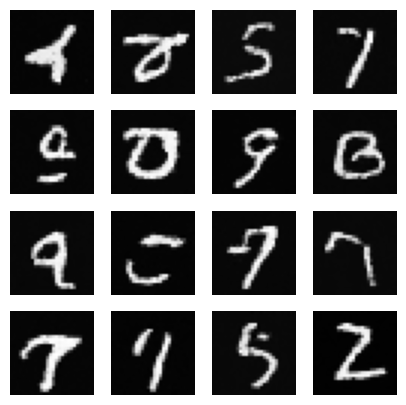

In [ ]:
inference_step(index = 1, show = True, save = False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Execution time for  60  epochs and  128  batch sizes:  1.9981188774108887


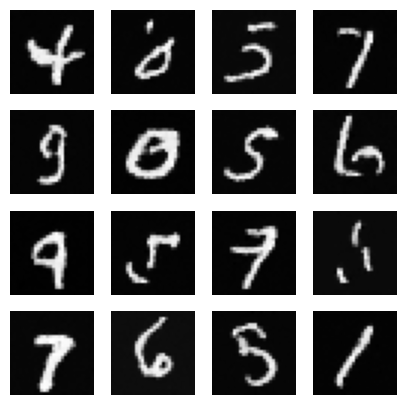

In [ ]:
inference_step(index = 1, show = True, save = False)

Execution time for  60  epochs and  64  batch sizes:  1.7952957153320312


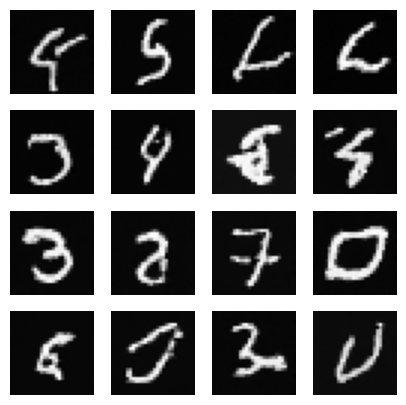

In [ ]:
inference_step(index = 2, show = True, save = False)

Execution time for  60  epochs and  128  batch sizes:  1.8634133338928223


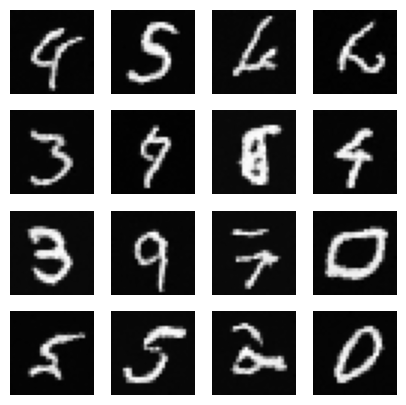

In [ ]:
inference_step(index = 2, show = True, save = False)

Execution time for  60  epochs and  64  batch sizes:  1.8145549297332764


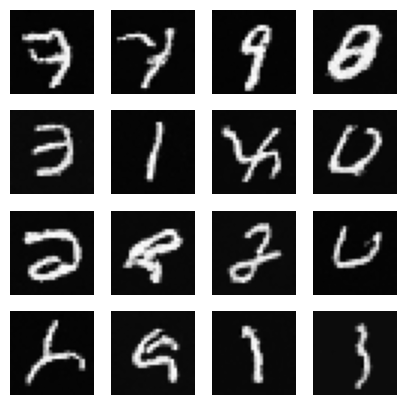

In [ ]:
inference_step(index = 3, show = True, save = False)

Execution time for  60  epochs and  128  batch sizes:  1.853576898574829


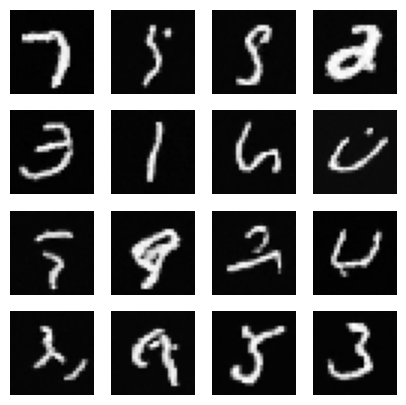

In [ ]:
inference_step(index = 3, show = True, save = False)

Execution time for  60  epochs and  64  batch sizes:  1.7974743843078613


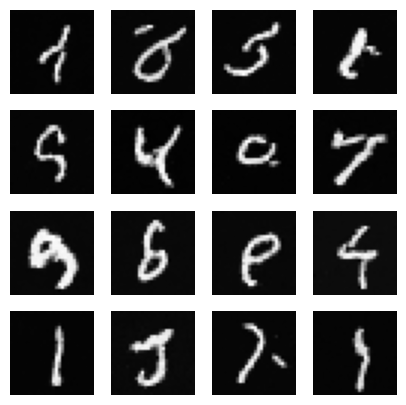

In [ ]:
inference_step(index = 4, show = True, save = False)

Execution time for  60  epochs and  128  batch sizes:  1.8335680961608887


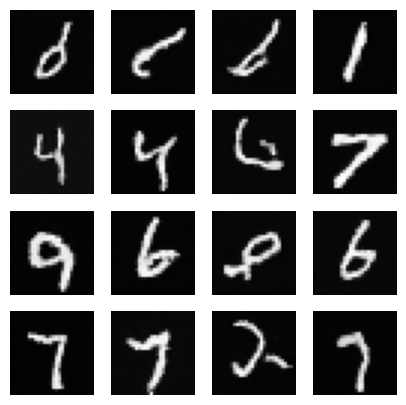

In [ ]:
inference_step(index = 4, show = True, save = False)

Execution time for  60  epochs and  64  batch sizes:  1.8262348175048828


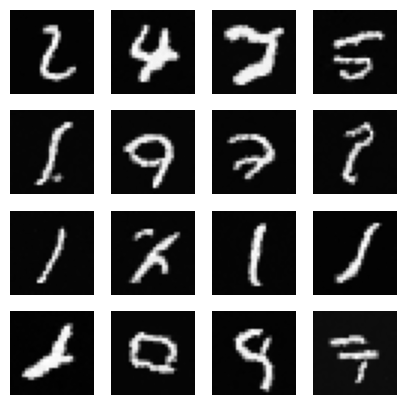

In [ ]:
inference_step(index = 5, show = True, save = False)

Execution time for  60  epochs and  128  batch sizes:  1.839545488357544


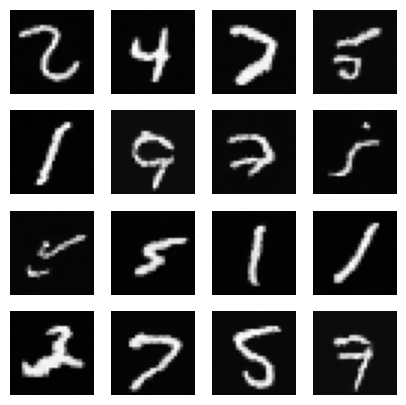

In [ ]:
inference_step(index = 5, show = True, save = False)

In [ ]:
upperbound_2 = int(10000/num_samples_generate)+1
print(upperbound_2)

626


In [ ]:
# Key interrupt because of the long processing time
for j in range(6, upperbound_2):
    inference_step(index = j, show = False, save = False)

KeyboardInterrupt: 

### FID score

In [ ]:
generated_img = np.asarray(generated_images)

In [ ]:
gen_images = []

In [ ]:
for i in range(len(generated_img)):
    for j in range(len(generated_img[0])):
        gen_images.append(generated_img[i][j])

In [ ]:
gen_images = np.asarray(np.round_(gen_images, decimals = 2))

In [ ]:
gen_images = gen_images.squeeze()
print(gen_images.shape)

(10000, 28, 28)


In [ ]:
for i in range(len(gen_images)):
    gen_images[i] = np.clip(gen_images[i], -1, 1)

In [ ]:
train_set = []
for i in range(len(dataset)):
  train_set.append(dataset[i][0])

In [ ]:
train_set = np.asarray(train_set)
# train_set = train_set.reshape(len(train_set), 28, 28)
print(train_set.shape)
# print(gen_images.shape)

(60000, 1, 28, 28)


In [ ]:
train_set = train_set.squeeze()

In [ ]:
train_set = np.round_(train_set, decimals = 2)

In [ ]:
print(train_set[20][20])

[-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -0.74  0.79  0.98  0.98  0.98  0.23 -0.97 -1.
 -1.   -1.   -1.   -1.  ]


In [ ]:
great_min = 1000
great_max = -1000

for i in range(len(gen_images)):
    temp_min = np.min(gen_images[i])
    temp_max = np.max(gen_images[i])
    if temp_min < great_min:
        great_min = temp_min
    if temp_max > great_max:
        great_max = temp_max

In [ ]:
print(great_min)
print(great_max)
# print(type(train_set[0][0][0]))
# print(type(gen_images[0][0][0]))

-1.0
1.0


In [ ]:
train_labels = dataset.targets.data.numpy()
print(train_labels.shape)

(60000,)


In [ ]:
print(gen_images.shape)
print(train_set.shape)

(10000, 28, 28)
(60000, 28, 28)


In [ ]:
gen_images = gen_images.reshape(len(gen_images), 28, 28, 1)
train_set = train_set.reshape(len(train_set), 28, 28, 1)

In [ ]:
import gc

gc.collect()

0

In [ ]:
from fid0 import FID_measure
import random

In [ ]:
fid00 = FID_measure(gen_images_ = gen_images, train_set_ = train_set, labels_ = train_labels)
train_set_shrinked, train_set_shrinked_labels = fid00.sample_uniformly()

Middle of Constructor
Train set len :  60000
End of Constructor
Middle of sample uniformly
Train set len :  10000
End of sample uniformly


In [ ]:
score = fid00.calculate_fid()
print('FID score: %.3f' % score)

beginning of calc_fid
gen_images len :  10000
Check whether shrink is not None
Train set len :  10000
313/313 [==============================] - 24s 57ms/step
gen_images solved
313/313 [==============================] - 15s 49ms/step
train_set solved
sigma1 solved
sigma2 solved
FID score: 16.180


### Mean and Covariance Matrix of Train and Generated Images

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(gen_images)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
gc.collect()

35783

### Inference time (average)

In [ ]:
print(len(inference_exe_time))

625


Mean inference time:  1.8319


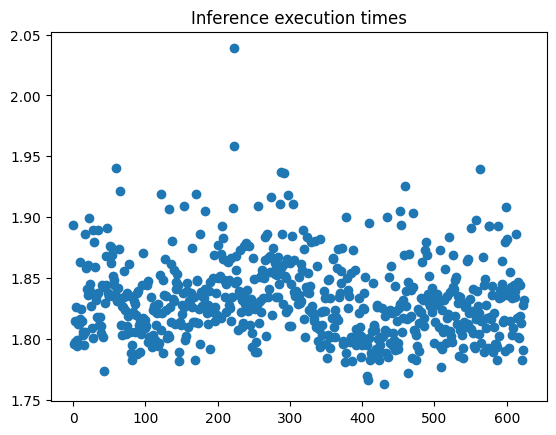

In [ ]:
plot_inference_exe_time(inference_exe_time)
print("Mean inference time: ", round(sum(inference_exe_time)/len(inference_exe_time), 4))

### CNN for Predicting Generated Images

In [ ]:
from keras.models import load_model
cnn = load_model('CNN.h5')

In [ ]:
preds_gen = cnn.predict(gen_images)
pred_labels_gen = np.argmax(preds_gen, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
unique_elements, counts = np.unique(pred_labels_gen, return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{0: 461, 1: 1876, 2: 811, 3: 1240, 4: 1097, 5: 1478, 6: 804, 7: 1271, 8: 500, 9: 462}


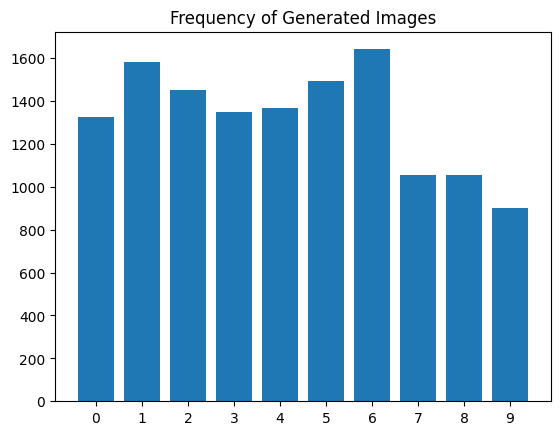

In [ ]:
plt.bar(unique_elements, counts)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Samples

In [ ]:
print(vectorized_gen.shape)
print(vectorized_train.shape)

(10000, 784, 1)
(10000, 784, 1)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()

def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print(pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

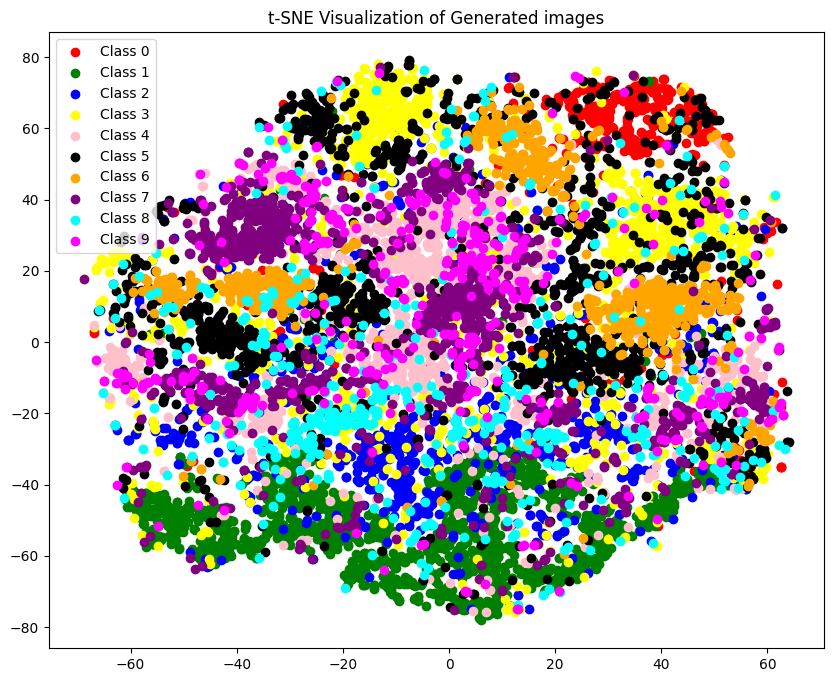

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], pred_labels_gen, 't-SNE Visualization of Generated images')

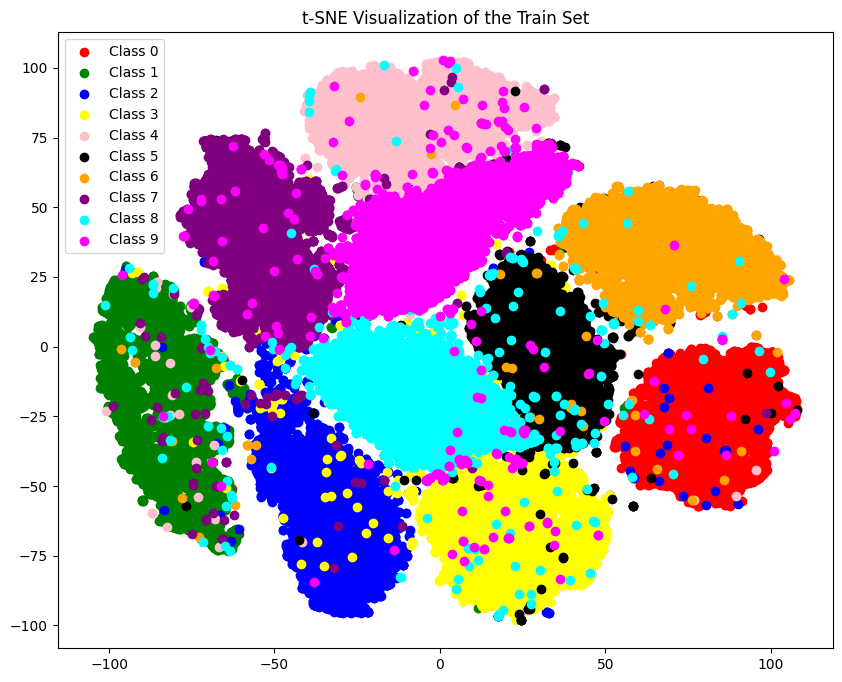

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], train_labels, 't-SNE Visualization of the Train Set')

### Precision, Recall, Density, Coverage measures

In [ ]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
_, _, vectorized_train_shrinked = calc_mu_and_sigma(train_set_shrinked)
reduced_dimension_train_shrinked = map_diversity(data = vectorized_train_shrinked, variance_PCA = 0.85)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train_shrinked,
                          fake_features = reduced_dimension_gen,
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.8244, 'recall': 0.8594, 'density': 0.6932400000000001, 'coverage': 0.6881}

----------------------------------

10 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.8784, 'recall': 0.8887, 'density': 0.69596, 'coverage': 0.8098}

----------------------------------

6 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.8407, 'recall': 0.8703, 'density': 0.6956499999999999, 'coverage': 0.734}

----------------------------------

3 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.7387, 'recall': 0.8079, 'density': 0.6541999999999999, 'coverage': 0.5283}

----------------------------------

2 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.6099, 'recall': 0.6895, 'density': 0.5825, 'coverage': 0.3843}

----------------------------------

1 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.3608, 'recall': 0.4108, 'density': 0.4383, 'cover

### SSIM Score

In [ ]:
ssim_score_list = gen_images[:280]

In [ ]:
from fid00 import FID_measure
fid_temp = FID_measure(gen_images_ = ssim_score_list, train_set_ = train_set, labels_ = train_labels)
train_set_shrinked_ssim, train_set_shrinked_labels_ssim = fid_temp.sample_uniformly(num_sample_per_class = int(len(ssim_score_list)/10))

Train set len :  60000
Middle of sample uniformly
Train set len :  280
End of sample uniformly


In [ ]:
print(ssim_score_list.shape)
print(train_set_shrinked_ssim.shape)

(280, 28, 28, 1)
(280, 28, 28, 1)


In [ ]:
ssim_score_list_3d = [[]]*len(ssim_score_list)
train_3d = [[]]*len(train_set_shrinked_ssim)

In [ ]:
for i in range(len(ssim_score_list)):
    ssim_score_list_3d[i] = np.concatenate([ssim_score_list[i], ssim_score_list[i], ssim_score_list[i]], axis = -1)

for i in range(len(train_set_shrinked_ssim)):
    train_3d[i] = np.concatenate([train_set_shrinked_ssim[i], train_set_shrinked_ssim[i], train_set_shrinked_ssim[i]], axis = -1)

In [ ]:
train_3d = np.asarray(train_3d)
ssim_score_list_3d = np.asarray(ssim_score_list_3d)

In [ ]:
print(train_3d.shape)
print(ssim_score_list_3d.shape)

(280, 28, 28, 3)
(280, 28, 28, 3)


In [ ]:
ssim_score_list_3d = ssim_score_list_3d * 255

In [ ]:
train_3d = train_3d * 255

In [ ]:
from ssim00 import SSIM

In [ ]:
ssim_mear = SSIM(ssim_score_list_3d, train_3d)

In [ ]:
score = ssim_mear.calc_score()

10.432969570159912 seconds (first)


In [ ]:
top_hundred = np.asarray(score)[np.asarray(score)[:, 0].argsort()]
top_hundred = top_hundred[::-1]
top_hundred = top_hundred[:100]

In [ ]:
print("The case of normilizing by *255")
for i in range(10):
    print(top_hundred[i][0], "\t", int(top_hundred[i][1]), "\t", int(top_hundred[i][2]))

The case of normilizing by *255
0.10715224593877792 	 163 	 65
0.10665220767259598 	 222 	 75
0.10627944767475128 	 104 	 55
0.1058509424328804 	 281 	 85
0.10544482618570328 	 45 	 45
0.10516024380922318 	 236 	 187
0.10501593351364136 	 273 	 273
0.10473591834306717 	 73 	 220
0.10467793792486191 	 73 	 122
0.10448560863733292 	 96 	 243


In [ ]:
ssim_scores = [top_hundred[i][0] for i in range(len(top_hundred))]

### Viewing Pairs of Generated-Train Images with High SSIM

In [ ]:
import gc
gc.collect()

similars_ssim = [top_hundred[i][1] for i in range(len(top_hundred))]
similar_train = [top_hundred[i][2] for i in range(len(top_hundred))]

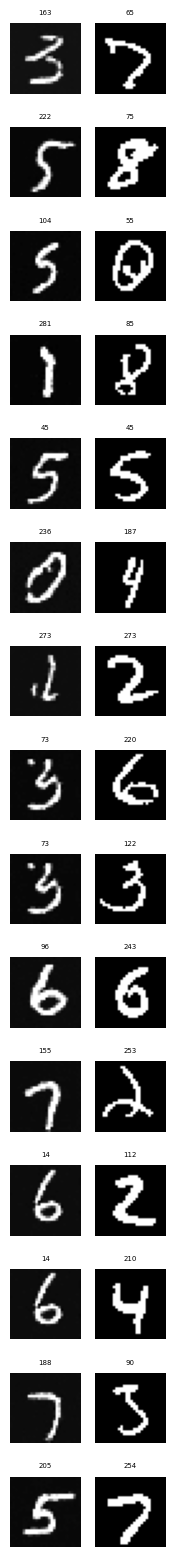

In [ ]:
fig = plt.figure(figsize=(2, 20))
rows = 15
columns = 2
j = 0
k = 0
for i in range(30):
    fig.add_subplot(rows, columns, i+1)
    if i % 2 == 0:
        plt.imshow(ssim_score_list[int(similars_ssim[k])], cmap = 'gray')
        plt.title(int(similars_ssim[k]), fontsize = 5)
        k += 1
    else:
        plt.imshow(train_3d[int(similar_train[j])])
        plt.title(int(similar_train[j]), fontsize = 5)
        j += 1
    plt.axis('off')